In [1]:
#___________________________________________________________________________________________________________________
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import os
import numpy as np
import time
import matplotlib.pyplot as pl
import pyvista as pv
import vtk
import tripyview as tpv

/home/pscholz/Python/tripyview


In [2]:
# Parameters
# mesh_path ='/home/pscholz/FESOM2.0/meshes/core2/'
mesh_path ='/home/pscholz/FESOM2.0/meshes/bold/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 3
which_mode= '3dsphere'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append(None)

input_names= list()
input_names.append('')

vname     = 'topo'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 100

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cmap      = 'rygbw'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
ncolumn       = 1 
do_rescale    = True
which_dpi     = 300
#_____________________________________________________________________________________
do_potatoefac = 0.6
do_topo       = True


In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        if ipath is not None: 
            input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            print(ii, input_paths[ii])
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
#______________________________________________________________________________________________________
cinfo=dict({'cstr':cmap, 'cnum':cnum})     
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

 > found *.pckl file: /home/pscholz/FESOM2.0/meshes/bold
 > load  *.pckl file: tripyview_fesom2_bold_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /home/pscholz/FESOM2.0/meshes/bold
 > id              = bold
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 1306775
 > #elem           = 2583730
 > #lvls           = 48
___________________________________________


In [4]:
# Smooth topography with a convolution filter
rel_cent_weight = 1.5 # >=1
num_iter        = 3
weaksmth_boxlist= []

# compute node neighbourhood
n_nghbr_n = tpv.do_node_neighbour(mesh)

data_smth = -np.abs(mesh.n_z)
# compute smoothing
data_smth = tpv.do_node_smoothing_fast(mesh, data_smth, n_nghbr_n, 
                              rel_cent_weight, num_iter)

mesh.n_z = -np.abs(data_smth)

 --> compute node neighbourhood
 --> compute node smoothing
     iter: 0
     iter: 1
     iter: 2


In [5]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    if depth =='bottom':
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=None, descript=ref_name, do_info=False) 
        data_ref = data_ref.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=depth, descript=ref_name, do_info=False) 

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=depth, descript=descript, do_info=False) 
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        data_list.append(do_anomaly(data, data_ref))
    else:
        data_list.append(data)  
    del(data)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth is not 'bottom') and do_clim and (ref_path is None): 
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    data_list.append(clim)    
    del(clim)

None


In [7]:
box = [-22, 4.25, 35.9, 50]
scalfac = 5
killdist= None

#___________________________________________________________________________
xs, ys, zs, e_i = mesh.n_x, mesh.n_y, -mesh.n_z, mesh.e_i
zs = zs**1/scalfac

#___________________________________________________________________________
# compute boundary edges 
bnde       = tpv.compute_boundary_edges(e_i)
bndn       = np.unique(bnde.flatten())
zs[bndn]   = 0.0 

# coordinates of all boundary nodes 
bndn_xs, bndn_ys = xs[bndn], ys[bndn]
idx_n      = tpv.grid_cutbox_n(bndn_xs, bndn_ys, box)
bndn_xs, bndn_ys = bndn_xs[idx_n], bndn_ys[idx_n]

#___________________________________________________________________________
# limit vertice array to box 
idx_e      = tpv.grid_cutbox_e(xs, ys, e_i, box, which='soft')
e_i        = e_i[idx_e, :] 

#___________________________________________________________________________
# re-index regional elem index
e_i, idx_n = tpv.reindex_regional_elem(e_i)
xs, ys, zs = xs[idx_n], ys[idx_n], zs[idx_n]

#___________________________________________________________________________
# limit xy vertice coordinates to box walls 
xs[xs<box[0]] = box[0]
xs[xs>box[1]] = box[1]
ys[ys<box[2]] = box[2]
ys[ys>box[3]] = box[3]

#___CREATE PYVISTA OCEAN MESH___________________________________________________________
meshpv_ocean_bottom  = tpv.create_3dflat_ocean_bottom( xs, ys, zs, e_i, data_list[0][vname][idx_n], vname=vname)
meshpv_ocean_surface = tpv.create_3dflat_ocean_surface(xs, ys, zs, e_i, bndn_xs, bndn_ys, killdist=killdist)
meshpv_ocean_wall_N  = tpv.create_3dflat_ocean_wall(   xs, ys, zs, e_i, which_wall='N', nsigma=20)
meshpv_ocean_wall_S  = tpv.create_3dflat_ocean_wall(   xs, ys, zs, e_i, which_wall='S', nsigma=20)
meshpv_ocean_wall_W  = tpv.create_3dflat_ocean_wall(   xs, ys, zs, e_i, which_wall='W', nsigma=20)
meshpv_ocean_wall_E  = tpv.create_3dflat_ocean_wall(   xs, ys, zs, e_i, which_wall='E', nsigma=20)
ocean_botwall        = tpv.create_3dflat_ocean_botwall(xs, ys, zs, e_i, scalfac)
    
#___CREATE PYVISTA LAND MESH TO FILL HOLES______________________________________________
meshpv_land, land_botwall = tpv.create_3dflat_land_mesh(mesh,
                                  box         = box,         
                                  resol       = 0.3,
                                  do_topo     = True, 
                                  topo_path   = '/home/pscholz/AWI/AWI_DATA/data_ETOPO5/topo_1deg.nc',
                                  topo_varname= 'topo',
                                  topo_dimname= ['lon','lat'],
                                  scalfac     = scalfac)
                                  
meshpv_botwall = tpv.combine_ocean_land_botwall(ocean_botwall, land_botwall)
# #
# #
# #___CREATE PYVISTA 3d COASTLINE, LONLAT GRID____________________________________________
# points_coast         = tpv.create_3dsphere_coastline(mesh)    
# points_lonlat_grid   = tpv.create_3dsphere_lonlat_grid(dlon=30,dlat=15,potatoefac=0.3,do_topo=do_topo)
# points_0lon0lat_grid = tpv.create_3dsphere_0lon0lat_grid(dlon=30,dlat=15,potatoefac=0.3,do_topo=do_topo)

 --> compute 3d flat ocean bottom mesh
 --> compute 3d flat ocean surface
 --> compute 3d flat ocean N wall
 --> compute 3d flat ocean S wall
 --> compute 3d flat ocean W wall
 --> compute 3d flat ocean E wall
 --> compute 3d flat ocean mesh
 --> compute 3d flat land mesh


In [23]:
#___CREATE PYVISTA OCEAN MESH___________________________________________________________
# do_mode    = 'interactive' # 'interactive', 'movie', 'print'
# do_mode    = 'movie' # 'interactive', 'movie', 'print'
do_mode    = 'print' # 'interactive', 'movie', 'print'
# do_wsize   = [5000,5000] #determines resolution when printing
# do_wsize   = [4000,4000] #determines resolution when printing
do_wsize   = [8000,8000] #determines resolution when printing
do_contour = True
do_gridline= True
do_smooth  = False
init_lon, init_lat, init_zoom = -30, 50, 1.75 #2

# lightning options
diffuse        = 0.6 #1.0
specular       = 0.5 #0.1 
specular_power = 15 #2
ambient        = 0.3 #0.1
metallic       = 0
roughness      = 0

# land texture options
do_landtexture= True
do_oceantexture = False
landcolor     = [0.6, 0.6, 0.6]
texture_file  = 'world.topo.bathy.200408.3x5400x2700.png'
# texture_file  = 'etopo1.jpg'
texture_path  = os.path.join(tpv.__path__[0], 'backgrounds/')
# 
#_______________________________________________________________________________________
# create custom colormap
vname = list(data_list[0].keys())[0]
print(vname)
cinfo = dict()
if any(x in vname for x in ['depth','topo','topography','zcoord']):  
#     cinfo['crange'], cinfo['cstr'], cinfo['cnum'] = [0, 6000, 3000], 'wbgyr', 20
#     cinfo['crange'], cinfo['cstr'], cinfo['cnum'] = [-6000, 0, -1500], 'cmocean.topo', 128
#     cinfo['crange'], cinfo['cstr'], cinfo['cnum'] = [-5500, 500, -4000], 'matplotlib.terrain', 72
    cinfo['crange'], cinfo['cstr'], cinfo['cnum'] = [-6000, 0, -4000], 'cmocean.turbid_i', 15
    
elif any(x in vname for x in ['nresol','n_resol','resolution','resol']):
    cinfo['cstr'  ] = 'rygbw'
    cinfo['crange'] = [20, 140, 80]
    cinfo['cnum'  ] = 15
cinfo = tpv.do_setupcinfo(cinfo, data_list, None, mesh, False)
clim = [cinfo['clevel'][0],cinfo['clevel'][-1]]

#_______________________________________________________________________________________
# create colorbar string
cbar_label, cbar_unit = None, None
if cbar_label is None     : cbar_label = data_list[0][vname].attrs['long_name']
if cbar_unit  is None     : cbar_label = cbar_label+' ['+data_list[0][ vname ].attrs['units']+']'
else                      : cbar_label = cbar_label+' ['+cbar_unit+']'
if 'str_ltim' in data_list[0][vname].attrs.keys(): cbar_label = cbar_label+'\n'+data_list[0][vname].attrs['str_ltim']
if 'str_ldep' in data_list[0][vname].attrs.keys(): cbar_label = cbar_label+data_list[0][vname].attrs['str_ldep']

#_______________________________________________________________________________________
# create pyvista plot object
# pv.set_plot_theme("default")
pv.set_plot_theme("document")
# pv.set_plot_theme("dark")
# pv.set_plot_theme("ParaView")

if do_mode=='print':
    pv.set_plot_theme("document")
    plt = pv.Plotter(notebook=True, off_screen=False, window_size=do_wsize, 
                     multi_samples=2, line_smoothing=None, polygon_smoothing=None, lighting=None)
    plt.background_color=None
elif do_mode=='movie':
    do_wsize = [2000,2000]
    plt = pv.Plotter(notebook=True,window_size=do_wsize,multi_samples=4, line_smoothing=True, polygon_smoothing=True)    
elif do_mode=='interactive':
    do_wsize = [2000,2000]
    plt = pv.Plotter(notebook=True, window_size=do_wsize,
                    multi_samples=4, line_smoothing=True, polygon_smoothing=True)

#_______________________________________________________________________________________
# colorbar arguments
fsize_label, fsize_title = 12, 24
linew1 = 2
if   do_mode=='print'      : 
    fsize_label, fsize_title = fsize_label*6, fsize_title*4
    linew1 = 4
elif do_mode=='interactive' or do_mode=='movie': 
    fsize_label, fsize_title = fsize_label*2, np.int16(fsize_title*1.5)
    linew1 = 1
dict_sargs = dict(
             title          = cbar_label,    
             vertical       = True, height=0.75, position_x=0.875, position_y=0.125,
             shadow         = True,
             title_font_size= fsize_title,
             label_font_size= fsize_label,
             fmt            = "%4.0f",
             n_labels       = np.int8(len(cinfo['clevel'])),#n_labels=np.int8(len(clevel)/2)+1,
             n_colors       = cinfo['cmap'].N,
             outline        = False)

dict_annot=dict()

# _______________________________________________________________________________________
texture=None
if do_landtexture : 
    texture   = pv.read_texture(os.path.join(texture_path, texture_file))
    landcolor = [0.99, 0.99, 0.99]
    #diffuse, specular, specular_power, ambient = 0.65, 0.2, 5, 0.65

# _______________________________________________________________________________________
# plot 3d ocean mesh
print('--> draw ocean mesh')
plt.add_mesh(meshpv_ocean_bottom, 
             #scalars=vname, clim=clim, cmap=cinfo['cmap'], n_colors=cinfo['cmap'].N,
             color=[0.9, 0.9, 0.9], 
             show_scalar_bar=False,
             diffuse=diffuse, specular=specular, specular_power=specular_power, ambient=ambient, #metallic=metallic, roughness=roughness, 
             smooth_shading=do_smooth,
             opacity=1.0)

# contours = meshpv_ocean_bottom.contour(scalars='topo', isosurfaces=np.sort(np.array([50,100,150,200,400,600, 800, 1000, 2000, 3000, 4000, 5000,6000]))*-1)
# plt.add_mesh(contours, color="black", line_width=5, smooth_shading=do_smooth)
# del contours

#_______________________________________________________________________________________
# plot 3d surfaceo ocean mesh 
which_dist = 3000
which_opac = 1.0
opacityscal = (np.tanh(-(meshpv_ocean_surface['dist']-which_dist)/100) + 1 )/2 * which_opac
plt.add_mesh(meshpv_ocean_surface, 
             color='w', 
             line_width=2.0,
             show_edges=True, 
             edge_color='w',
             texture=texture,
             smooth_shading=False,
             opacity=opacityscal,)

#_______________________________________________________________________________________
# plot 3d land mesh
print('--> draw land mesh')
plt.add_mesh(meshpv_land, color=landcolor, texture=texture, smooth_shading=do_smooth, 
             diffuse=diffuse, specular=specular, specular_power=specular_power, ambient=ambient)

# _______________________________________________________________________________________
# plot 3d ocean northern wall
print('--> draw ocean northern wall mesh')
nsigma   = 20
dsigma   = np.logspace(0, 1, num=nsigma, endpoint=True, base=100.0)
dsigma   = dsigma-dsigma.min()
dsigma   = dsigma/dsigma.max()
plt.add_mesh(meshpv_ocean_wall_S.contour(scalars='sigma', isosurfaces=dsigma), color="r", line_width=4)
# plt.add_mesh(meshpv_ocean_wall_N.contour(scalars='sigma', isosurfaces=dsigma), color="r", line_width=4)
# plt.add_mesh(meshpv_ocean_wall_W.contour(scalars='sigma', isosurfaces=dsigma), color="r", line_width=4)
# plt.add_mesh(meshpv_ocean_wall_E.contour(scalars='sigma', isosurfaces=dsigma), color="r", line_width=4)

# _______________________________________________________________________________________
# plot 3d ocean box mesh
print('--> draw ocean box mesh')
plt.add_mesh(meshpv_botwall, 
             color=[0.99, 0.99, 0.99], 
             show_edges=False, 
             edge_color='black',
             diffuse=diffuse, specular=specular, specular_power=specular_power, ambient=ambient,
             smooth_shading=do_smooth)

# _______________________________________________________________________________________
# add black feature lines 
plt.add_mesh(meshpv_ocean_wall_S.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
plt.add_mesh(meshpv_ocean_wall_N.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
plt.add_mesh(meshpv_ocean_wall_E.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
plt.add_mesh(meshpv_ocean_wall_W.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
plt.add_mesh(meshpv_ocean_surface.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
plt.add_mesh(meshpv_ocean_bottom.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')
# plt.add_mesh(meshpv_botwall.extract_feature_edges(feature_edges=False, boundary_edges=True, manifold_edges=False), line_width=4, color='k')

#_______________________________________________________________________________________
# do save as png
# https://nbviewer.org/github/banesullivan/damavand-volcano/blob/master/Damavand_Volcano.ipynb
dx, dy = box[1]-box[0], box[3]-box[2]
xs, ys = 1, 0.5
if dx>dy: ys = ys*((box[1]-box[0])/(box[3]-box[2]))
else    : xs = xs*((box[3]-box[2])/(box[1]-box[0]))    
plt.set_scale(xscale=xs, yscale=ys, zscale=-0.0065)  
print(xs, ys)    

# plt.camera_position = [ np.array([-40,41,3000]), (0,0,0), (5,41,0)] 
plt.camera_position  = 'xz'
plt.camera.azimuth   = -5
plt.camera.elevation = 25
plt.camera.roll      = 9

# light = pv.Light(light_type='headlight')
light = pv.Light(position=(box[2]+dy/2, box[0]+dx/2, -1000), light_type='scene light')
# light = pv.Light(position=(box[0]+dx/2, box[2]+dy/2, -10000), light_type='camera light')
plt.add_light(light)

# plt.add_text('Patrick.Scholz@awi.de, FESOM2 developer team',position=[0.8*do_wsize[0], 0.23*do_wsize[1]], #position='upper_right', 
plt.add_text('Patrick.Scholz@awi.de, FESOM2 developer team',position=[0.06*do_wsize[0], 0.23*do_wsize[1]], #position='upper_right',              
             font_size=32, color=[0.5, 0.5, 0.5], shadow=True)         

# plt.enable_parallel_projection()
plt.disable_parallel_projection()
plt.camera.zoom(1.05)

#_______________________________________________________________________________________
# do slider widget infrastructure for interactive plotting
R_earth    =  6371.0e3
if do_mode == 'interactive':
    plt.show()
else:    
    fname = 'test_image_3dsphere_'+vname
    print('--> print screenshot')
    
    plt.screenshot(filename=fname+'.png', window_size=do_wsize, transparent_background=False)
    
    plt.save_graphic(fname+'.eps', title='PyVista Export', raster=True, painter=True)
    
    plt.show(jupyter_backend='static')
#     plt.show(jupyter_backend='ipygany')
#     plt.show(jupyter_backend='pythreejs')
#     plt.show(jupyter_backend='ipyvtklink')
#     plt.show(jupyter_backend='panel')
#     plt.show(jupyter_backend='none')
#     plt.show()

topo
{'crange': [-6000, 0, -4000], 'cstr': 'cmocean.turbid_i', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cmin': -6000, 'cmax': 0, 'cref': -4000, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ff8455fc4d0>, 'clevel': array([-6000., -5750., -5500., -5250., -5000., -4750., -4500., -4250.,
       -4000., -3750., -3500., -3250., -3000., -2750., -2500., -2250.,
       -2000., -1750., -1500., -1250., -1000.,  -750.,  -500.,  -250.,
           0.])}
--> draw ocean mesh
--> draw land mesh
--> draw ocean northern wall mesh
--> draw ocean box mesh
1 0.9308510638297871
--> print screenshot


[0.         0.00277045 0.00630078 0.01079937 0.01653183 0.02383655
 0.03314477 0.04500601 0.06012048 0.07938048 0.10392302 0.13519696
 0.17504856 0.22583045 0.29054055 0.37299901 0.47807376 0.61196789
 0.78258583 1.        ]


<IPython.core.display.Javascript object>


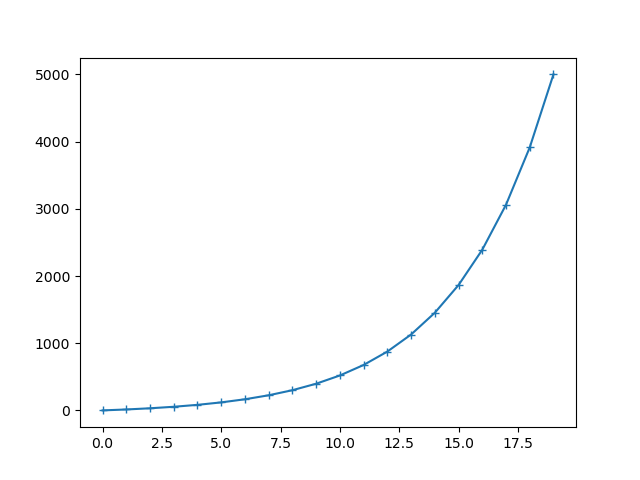